# Drug Consumption Classification Model

## Importing Dependencies

In [3612]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, RFECV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve

## Data Loading

In [3613]:
# Load drug consumption data
df = pd.read_csv("./drug_consumption.csv")

In [3614]:
# Split DataFrame into input features and output classes
inputs = df.loc[:, 'age':'sensationSeeking']
output = df.loc[:, 'nicotineConsumption']

## Check if Data is Clean

In [3615]:
# Check for null or NaN entries
dfFull.isnull().sum().sum() + dfFull.isna().sum().sum()

0

In [3616]:
# Check for duplicate records
bool_series = dfFull.duplicated().to_numpy()
bool_series.sum()

0

## Label Encoding

In [3617]:
# Encode output classes with ordinal labelling
def encodeLabelsForBinary(label):
    if (label=='CL0' or label=='CL1'):
        return(0)
    else:
        return(1)

def encodeLabelsForMulticlass(label):
    if (label=='CL0'):
        return(0)
    elif (label=='CL1'):
        return(1)
    elif (label=='CL2'):
        return(2)
    elif (label=='CL3'):
        return(3)
    elif (label=='CL4'):
        return(4)
    elif (label=='CL5'):
        return(5)
    elif (label=='CL6'):
        return(6)

output = output.apply(encodeLabelsForMulticlass)

## Data Analysis and Visualisation

In [3618]:
df.describe()

,id,age,gender,education,country,ethnicity,neuroticism,extraversion,opennessToExperience,agreeableness,conscientiousness,impulsiveness,sensationSeeking
count,1885.000000,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,945.294960,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,545.167641,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,1.000000,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,474.000000,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,946.000000,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,1417.000000,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,1888.000000,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


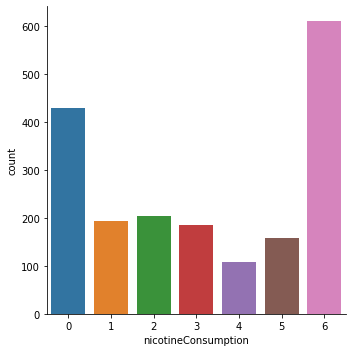

In [3619]:
# Visualising dataset imbalance
df = pd.concat([inputs, output], axis=1)
seaborn.catplot(x='nicotineConsumption', data=df, kind='count')

<AxesSubplot:xlabel='value', ylabel='variable'>

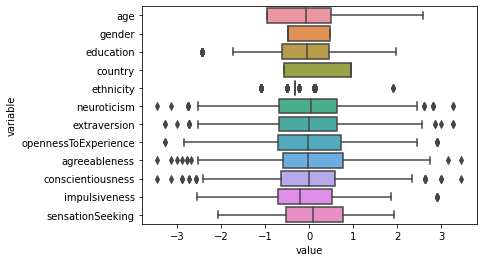

In [3620]:
# Visualising feature distributions
meltedFeatures = inputs.copy()
meltedFeatures = pd.melt(meltedFeatures)
seaborn.boxplot(x="value", y="variable", data=meltedFeatures)

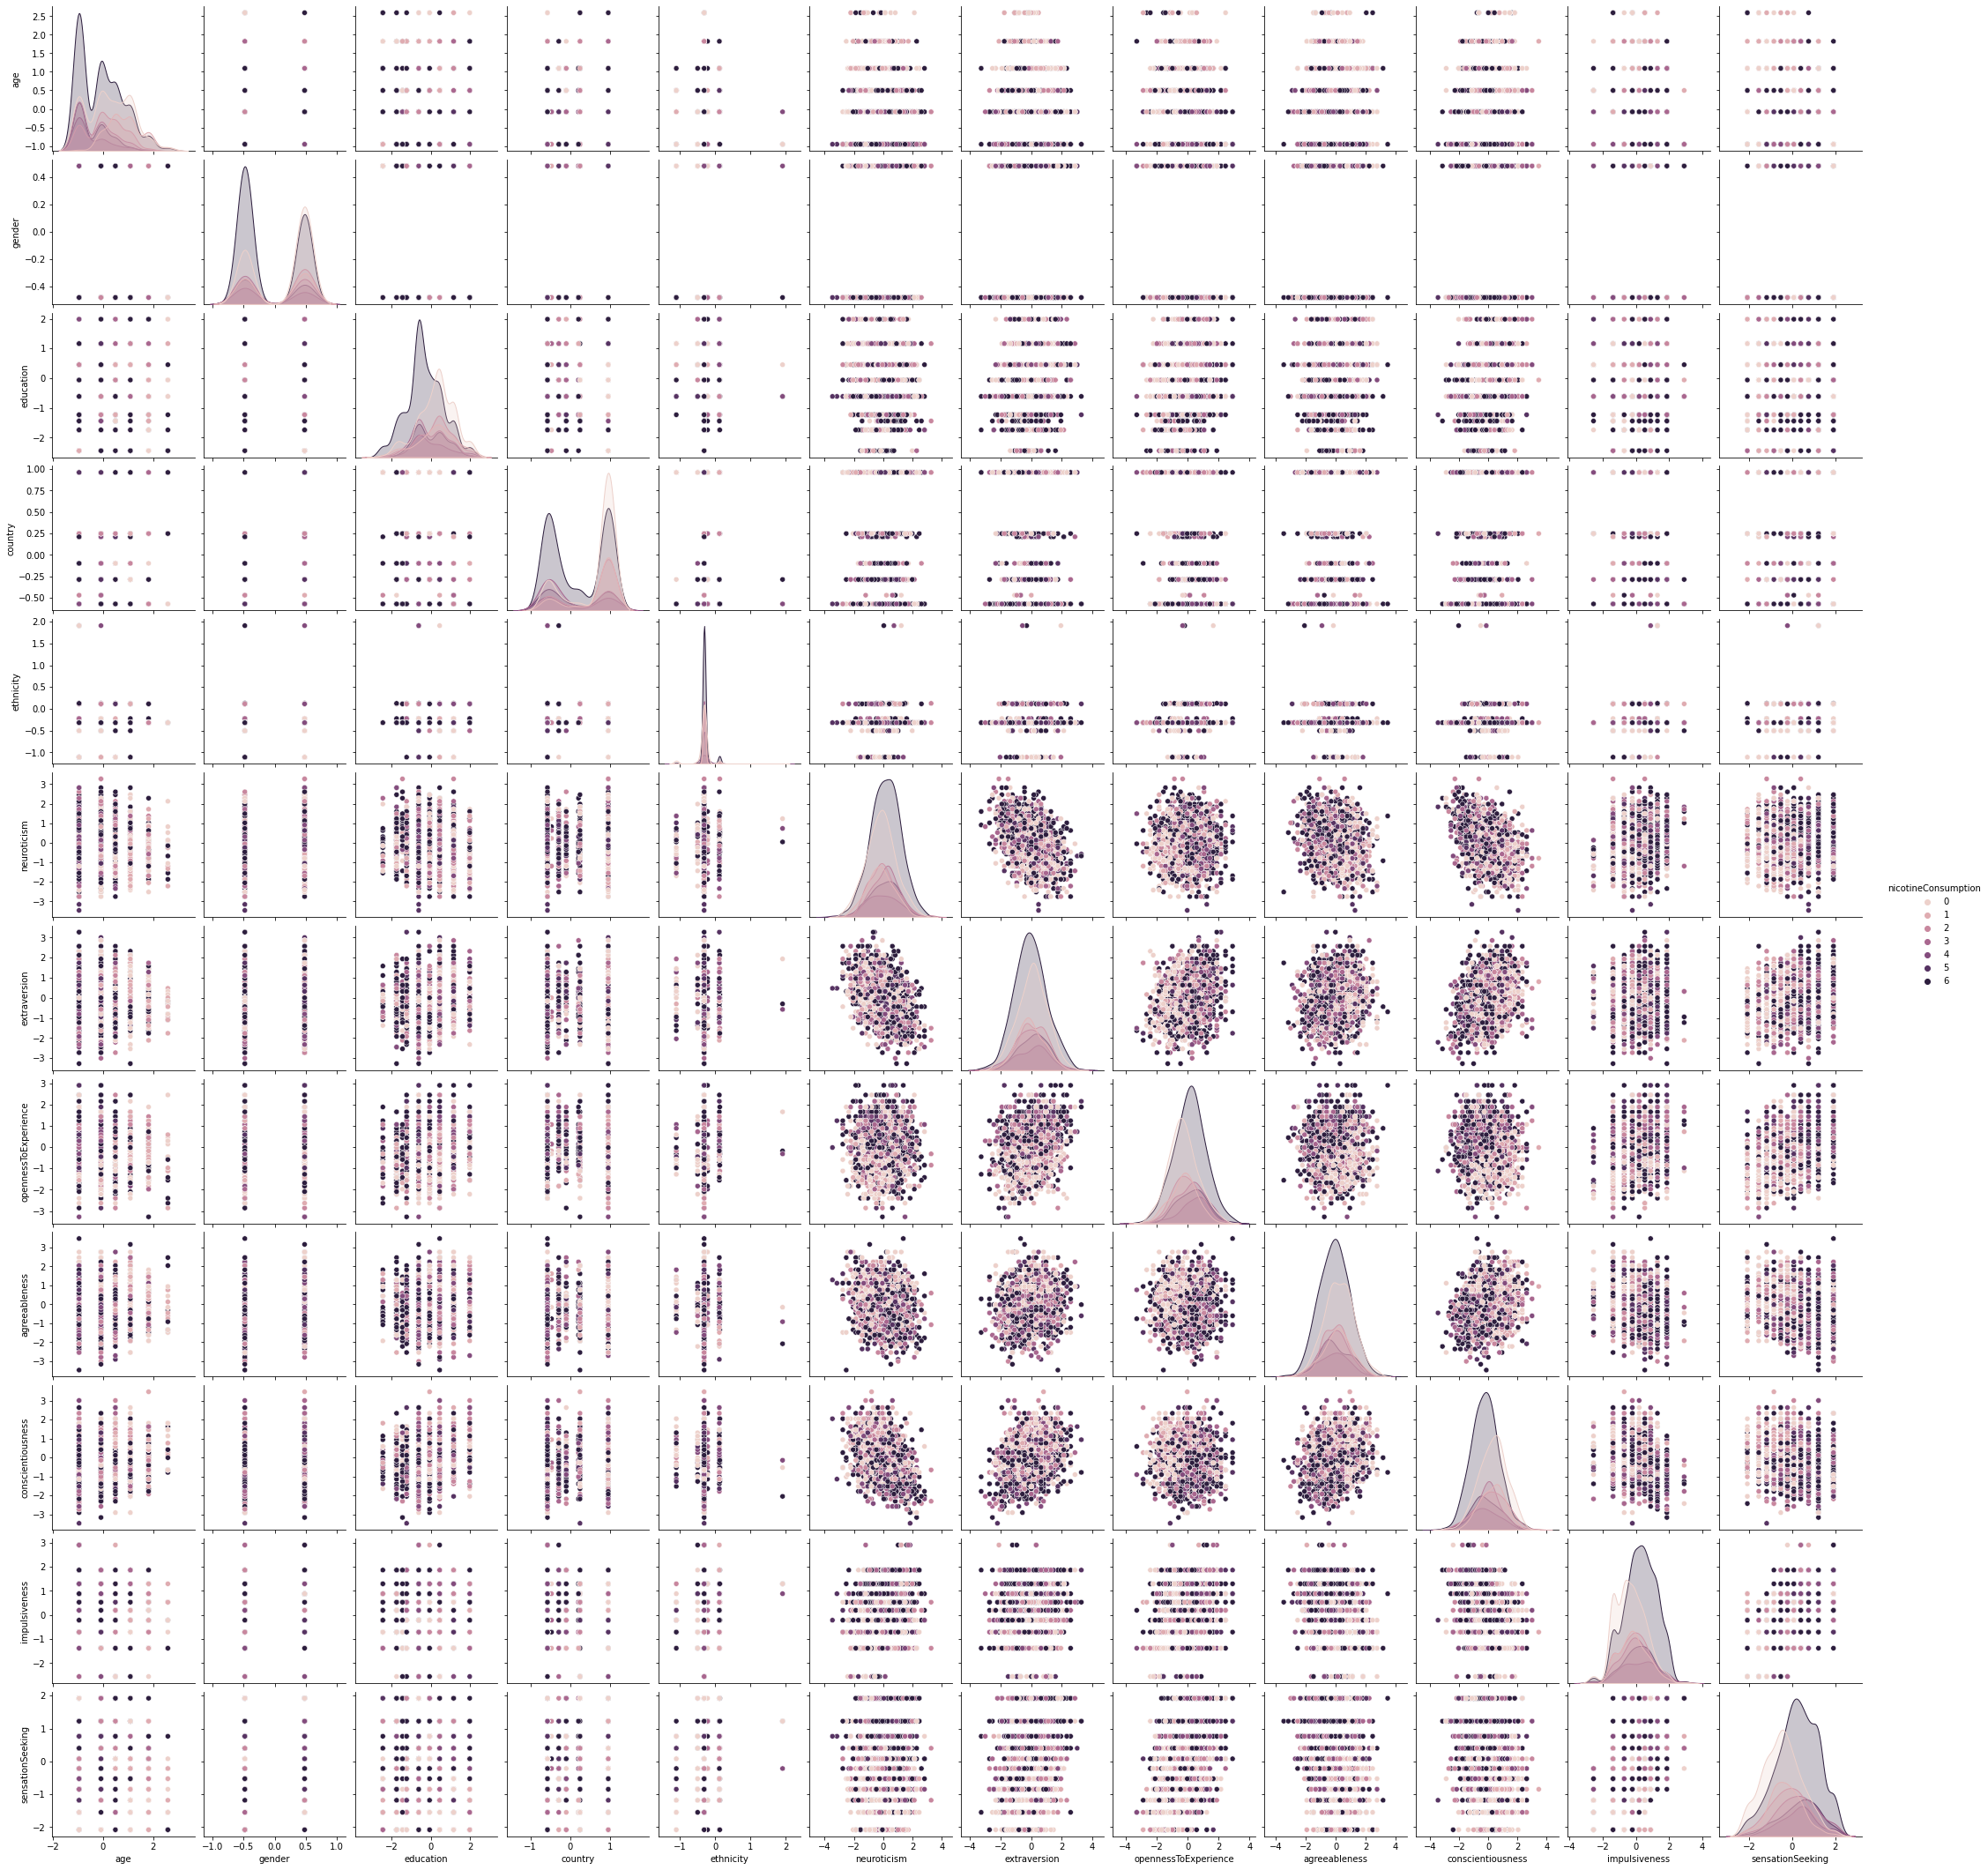

In [3621]:
# Visualising all pairwise bivariate distributions between features and nicotineConsumption classification
seaborn.pairplot(df, hue='nicotineConsumption', height=2.5)

<AxesSubplot:>

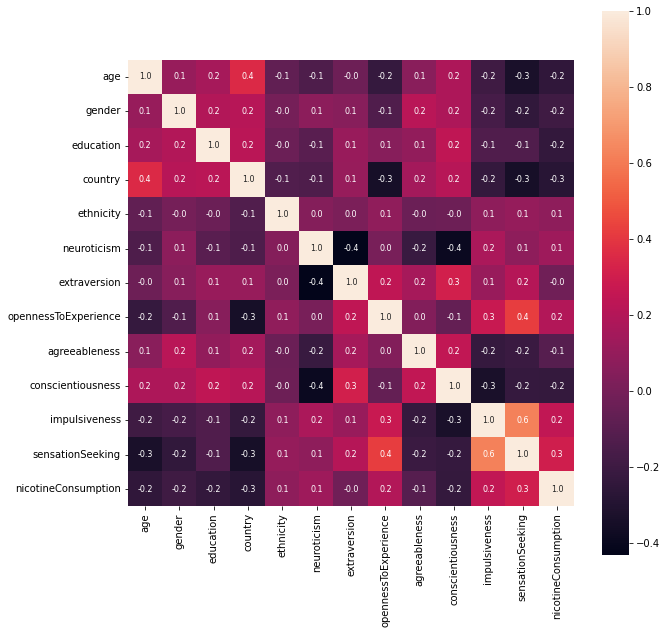

In [3622]:
# Visualising feature correlation
correlation = df.corr()
plt.figure(figsize=(10, 10))
seaborn.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8})

## Train and Test Split

In [3623]:
# Split the dataset into training/validation and testing subsets
X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.3, shuffle=True, random_state=42)

## Polynomial Expansion

In [3624]:
applyPolynomialExpansion = False
if (applyPolynomialExpansion):
    poly = PolynomialFeatures(degree=2)
    X_train_numpy_array = poly.fit_transform(X_train)
    X_test_numpy_array = poly.fit_transform(X_test)
    features = ['age', 'gender', 'education', 'country', 'ethnicity', 'neuroticism', 'extraversion', 'opennessToExperience', 'agreeableness', 'conscientiousness', 'impulsiveness', 'sensationSeeking']
    newColumns = poly.get_feature_names(features)
    X_train = pd.DataFrame(X_train_numpy_array, columns=newColumns)
    X_test = pd.DataFrame(X_test_numpy_array, columns=newColumns)

## Data Preprocessing

In [3625]:
# Normalise input data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_numpy_array = scaler.transform(X_train)
X_test_numpy_array = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_numpy_array, columns=X_train.columns)
X_test = pd.DataFrame(X_test_numpy_array, columns=X_test.columns)

## Create LogisticRegression

In [3626]:
# Instantiate sklearn LogisticRegression model
model = LogisticRegression(max_iter=1000)

## Feature Subset Selection

In [3627]:
# Feature selection via univariate tests
# Optimal k found to be 7 after testing model at all k between 12 and 1
# k = 7
# selectKBest = SelectKBest(k=k).fit(X_train, y_train)
# X_train_subset = selectKBest.transform(X_train)

# Set X_train and X_test to new DataFrames including the K best features
# dfScores = pd.DataFrame(selectKBest.scores_)
# dfColumns = pd.DataFrame(X_train.columns)
# featureScores = pd.concat([dfColumns, dfScores], axis=1)
# featureScores.columns = ['Feature', 'Score']
# bestKFeatures = featureScores.nlargest(k, 'Score')['Feature'].to_numpy()
# X_train = X_train.loc[:, X_test.columns.isin(bestKFeatures)]
# X_test = X_test.loc[:, X_test.columns.isin(bestKFeatures)]
print("Discarded SelectKBest method")

Discarded SelectKBest method


In [3628]:
# Feature subset selection via recursive feature elimination with cross validation
rfecv = RFECV(estimator = model, step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)
print('Optimal number of features: {}'.format(rfecv.n_features_))
optimalFeatureSubset = X_train.columns[rfecv.support_]
print('Optimal feature subset: {}'.format(optimalFeatureSubset))
X_train = rfecv.transform(X_train)
X_test = rfecv.transform(X_test)

Optimal number of features: 10
Optimal feature subset: Index(['age', 'education', 'country', 'ethnicity', 'neuroticism',
       'extraversion', 'opennessToExperience', 'conscientiousness',
       'impulsiveness', 'sensationSeeking'],
      dtype='object')


## Hyperparameter Optimisation Using GridSearchCV

In [3629]:
# Set of hyperparameters to optimise
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-4, 4, 40),
        'solver': ['liblinear'],
        'max_iter': [100, 1000, 2500, 5000],
        'multi_class': ['ovr'],
        'class_weight': ['balanced']
    }
]

In [3630]:
# Find best classifier hyperparameters
classifier = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
bestClassifier = classifier.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


## Model Training

In [3631]:
# Set model as best estimator found by grid search
model = classifier.best_estimator_

In [3632]:
# Train LogisticRegression model
model.fit(X_train, y_train)

LogisticRegression(C=0.007017038286703823, class_weight='balanced',
                   multi_class='ovr', solver='liblinear')

## Model Evaluation

In [3633]:
# Set k fold cross validation parameters
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Calculate cross validation score of best model
results = cross_val_score(model, X_train, y_train, cv=kfold)

In [3634]:
# Print model k fold cross validation accuracy
print("K fold cross validation accuracy: {}% ({}%)".format(results.mean()*100, results.std()*100))

K fold cross validation accuracy: 39.72635096209241% (1.4840411016558646%)


In [3635]:
# Print model training accuracy
print("Training accuracy: {}%".format(model.score(X_train, y_train)*100))

Training accuracy: 39.72706595905989%


In [3636]:
# Print model testing accuracy
print("Testing accuracy: {}%".format(model.score(X_test, y_test)*100))

Testing accuracy: 40.63604240282685%


In [3637]:
# Calculate model predictions of testing data
y_hat = model.predict(X_test)

In [3638]:
# Decode class labels
classLabels = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']
y_hat = pd.Series(y_hat)

def decodeClassLabelsForBinary(label):
    if (label==0 or label==1):
        return('Non-user')
    else:
        return('User')

def decodeClassLabelsForMulticlass(label):
    return(classLabels[label])
        
# y_test = y_test.apply(decodeClassLabelsForMulticlass)
# y_hat = y_hat.apply(decodeClassLabels)

Text(0.5, 15.0, 'Predicted Label')

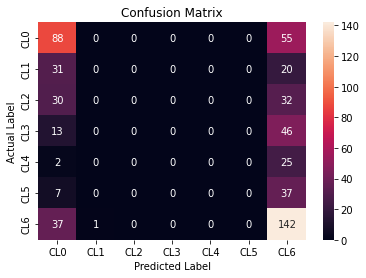

In [3639]:
# Calculate the confusion matrix
dfConfusionMatrix = pd.DataFrame(confusion_matrix(y_test, y_hat), index=classLabels, columns=classLabels)
seaborn.heatmap(dfConfusionMatrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

In [3640]:
# Display classification evaluation metrics
print(classification_report(y_test, y_hat, zero_division=0))
print("Micro average precision = {}".format(round(precision_score(y_test, y_hat, average='micro', zero_division=0), 2)))
print("Micro average recall = {}".format(round(recall_score(y_test, y_hat, average='micro', zero_division=0), 2)))

              precision    recall  f1-score   support

           0       0.42      0.62      0.50       143
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00        27
           5       0.00      0.00      0.00        44
           6       0.40      0.79      0.53       180

    accuracy                           0.41       566
   macro avg       0.12      0.20      0.15       566
weighted avg       0.23      0.41      0.29       566

Micro average precision = 0.41
Micro average recall = 0.41


<AxesSubplot:>

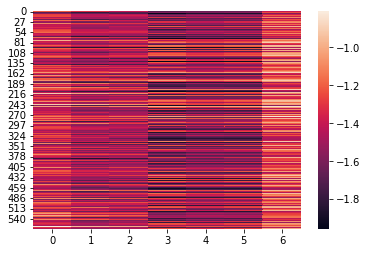

In [3641]:
# Visualise confidence scores for test data
confidence = model.decision_function(X_test)
# fig, ax = plt.subplots(figsize=(10, 100))
seaborn.heatmap(confidence)

<AxesSubplot:>

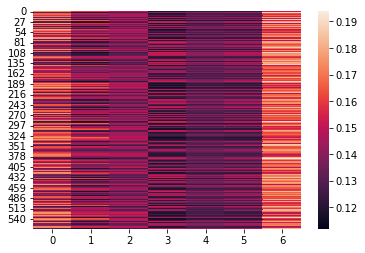

In [3642]:
# Visualise probability estimates for test data
probEstimates = model.predict_proba(X_test)
# fig, ax = plt.subplots(figsize=(10, 100))
seaborn.heatmap(probEstimates)

Text(0.5, 1.0, 'precision vs. recall curve')

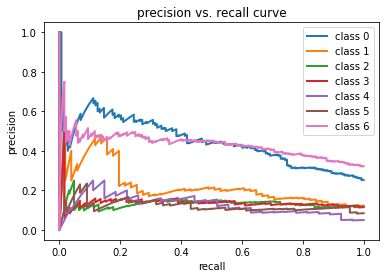

In [3643]:
# Plot the Precision-Recall curves for each class of nicotine consumption
precision = dict()
recall = dict()
y_test_for_curve = y_test.copy()
for i in range(7):
    precision[i], recall[i], _ = precision_recall_curve(y_test_for_curve, probEstimates[:, i], pos_label=i)
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")

In [3644]:
# Calculate the arithmetic mean of areas under the receiver operating characteristic curves
print(roc_auc_score(y_test, probEstimates, multi_class='ovr', average='macro'))

0.6718890058818754

In [3645]:
# Calculate the weighted average of areas under the receiver operating characteristic curves
print(roc_auc_score(y_test, probEstimates, multi_class='ovr', average='weighted'))

0.6648440635576849

Text(0.5, 1.0, 'ROC curve')

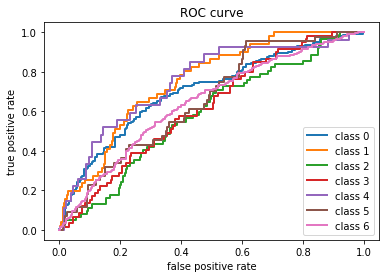

In [3646]:
# Plot the Receiver Operating Characteristic (ROC) curves for each class of nicotine consumption
falsePositiveRate = dict()
truePositiveRate = dict()

for i in range(7):
    falsePositiveRate[i], truePositiveRate[i], _ = roc_curve(y_test_for_curve, probEstimates[:, i], pos_label=i)
    plt.plot(falsePositiveRate[i], truePositiveRate[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")

## Final Results

### K fold cross validation accuracy:
- 40.49% (0.81%)

### Training accuracy:
- 39.73%

### Testing accuracy:
- 40.64%

### Model Parameters:
- C = 0.007017038286703823
- multi_class = 'ovr'
- penalty = 'l1'
- solver = 'liblinear'
- class_weight = 'balanced'